In [7]:
import os
import math
import json
import pytz
import requests
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
import pandas as pd

In [3]:
bucket = "https://alplakes-eawag.s3.eu-central-1.amazonaws.com"
bucket_key = bucket.split(".")[0].split("//")[1]

In [4]:
class boto3(object):
    def __init__(self):
        self.intialise = ""
    def upload_file(self, file, bucket, path):
        print(file, bucket, path)

s3 = boto3()

In [5]:
lake = "geneva"
model = "delft3d-flow"
api = "https://alplakes-api.eawag.ch"

In [13]:
# Collect model metadata
response = requests.get("{}/simulations/metadata/{}/{}".format(api, model, lake))
if response.status_code != 200:
    raise ValueError("Unable to access {}/simulations/metadata/{}/{}".format(api, model, lake))
lake_metadata = response.json()


# Get version of website metadata
branch = "master"
try:
    response = requests.get("https://raw.githubusercontent.com/eawag-surface-waters-research/alplakes-react/refs/heads/master/src/config.json")
    if response.status_code == 200:
        branch = response.json()["branch"]
except:
    print("Failed to find branch")

default_depth = 1
default_period = -6
response = requests.get("{}/static/website/metadata/{}/{}.json".format(bucket, branch, lake))
if response.status_code != 200:
    raise ValueError("Unable to access {}/static/website/metadata/{}/{}.json".format(bucket, branch, lake))
lake_info = response.json()
try:
    default_depth = lake_info["properties"]["default_depth"]
except:
    print("Failed to collect custom depth, using default of {}".format(default_depth))
    
# Performance
try:
    if "live" in lake_info["forecast"]["3d_model"]["performance"]:
        live = lake_info["forecast"]["3d_model"]["performance"]["live"].copy()
        stop = datetime.now() - timedelta(days=1)
        stop = stop.replace(hour=23, minute=0, second=0, microsecond=0)
        start = stop - timedelta(days=10)
        rmse_total = []
        for location in live:
            for depth in live[location]["depth"]:
                try:
                    if live[location]["type"] == "datalakes":
                        live[location]["depth"][depth]["insitu"] = download_datalakes_data(live[location]["id"], live[location]["depth"][depth]["depth"], start, stop)
                    else:
                        raise ValueError("Unrecognised data source")
                    response = requests.get("{}/simulations/point/{}/{}/{}/{}/{}/{}/{}?variables=temperature".format(api, model, lake, start.strftime("%Y%m%d2300"), stop.strftime("%Y%m%d2300"), live[location]["depth"][depth]["depth"], live[location]["lat"], live[location]["lng"]))    
                    if response.status_code != 200:
                        raise ValueError("Failed to get model values")
                    out = response.json()
                    live[location]["depth"][depth]["model"] = {"time": out["time"], "values": out["variables"]["temperature"]["data"]}
                    rmse = calculate_rmse(live[location]["depth"][depth]["model"], live[location]["depth"][depth]["insitu"])
                    if isinstance(rmse, float) and not math.isnan(rmse):
                        rmse_total.append(rmse)
                        live[location]["depth"][depth]["rmse"] = round(rmse, 1)
                except:
                    print("Failed to collect insitu")
        if len(rmse_total) > 0:
            lake_metadata["rmse"] = round(np.nanmean(np.array(rmse_total)), 1)
            with open("performance.json",mode='w') as temp_file:
                json.dump(live, temp_file)
            with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_file:
                temp_filename = temp_file.name
                json.dump(live, temp_file)
            s3.upload_file(temp_filename, bucket_key, "simulations/{}/cache/{}/performance.json".format(model, lake))
except:
    print("Live performance failed")

/tmp/tmpxvxde8pz alplakes-eawag simulations/delft3d-flow/cache/geneva/performance.json


In [ ]:
def calculate_rmse(dataset1, dataset2):
    """
    Calculate the Root Mean Square Error (RMSE) between two datasets,
    where one dataset has timestamps every 3 hours and the other has timestamps every 10 minutes.
    Only consider a 10-minute timestamp if it is within 20 minutes of the 3-hour timestamp.

    Args:
        dataset1 (dict): A dictionary with 'time' (every 3 hours) and 'values' lists for the first dataset.
        dataset2 (dict): A dictionary with 'time' (every 10 minutes) and 'values' lists for the second dataset.

    Returns:
        float: The RMSE value.
    """
    # Convert time strings to datetime objects for easier manipulation
    time1 = [datetime.fromisoformat(t) for t in dataset1['time']]
    time2 = [datetime.fromisoformat(t) for t in dataset2['time']]

    # Time threshold for matching (20 minutes)
    time_threshold = timedelta(minutes=20)

    # For each time in dataset1 (3-hour points), find the closest time in dataset2 (10-min points)
    aligned_values1 = []
    aligned_values2 = []
    
    for t1 in time1:
        # Find the closest time in dataset2 that is within 20 minutes of t1
        valid_times = [t2 for t2 in time2 if abs(t2 - t1) <= time_threshold]
        
        if valid_times:
            # Find the closest time from the valid options
            closest_time = min(valid_times, key=lambda t2: abs(t2 - t1))
            # Get the index of the closest time in dataset2
            index2 = time2.index(closest_time)
            
            # Append the corresponding values to the aligned lists
            aligned_values1.append(float(dataset1['values'][time1.index(t1)]))  # Ensure it's a float
            aligned_values2.append(float(dataset2['values'][index2]))  # Ensure it's a float

    # Ensure both lists of aligned values have the same length
    if len(aligned_values1) != len(aligned_values2):
        raise ValueError("The datasets do not align properly in time or length.")

    # Compute the squared differences between corresponding values
    squared_differences = [(v1 - v2)**2 for v1, v2 in zip(aligned_values1, aligned_values2)]

    # Calculate RMSE
    mse = np.mean(squared_differences)
    rmse = np.sqrt(mse)

    return rmse

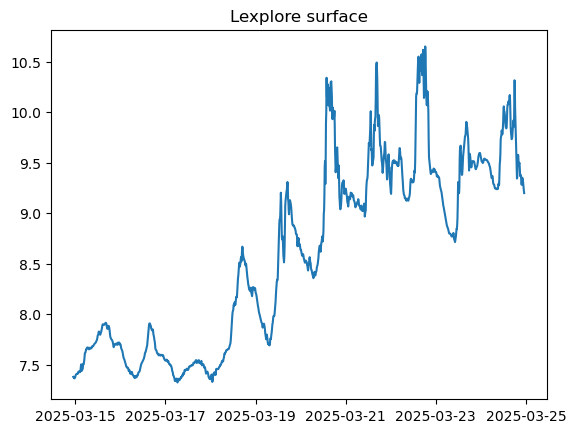

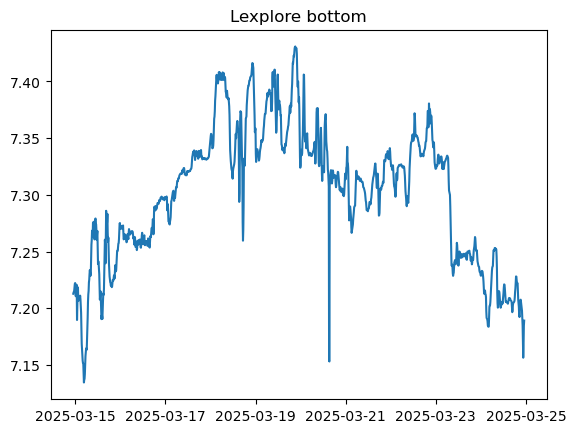

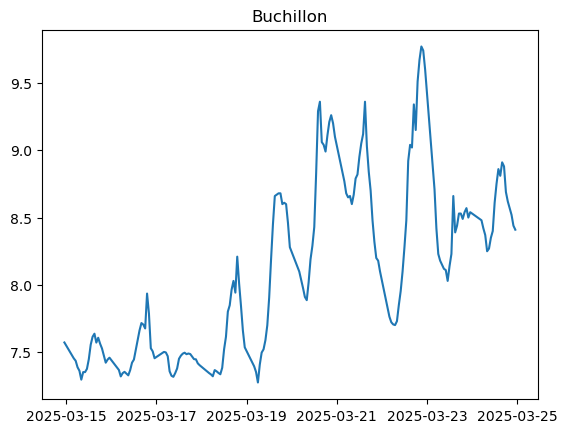

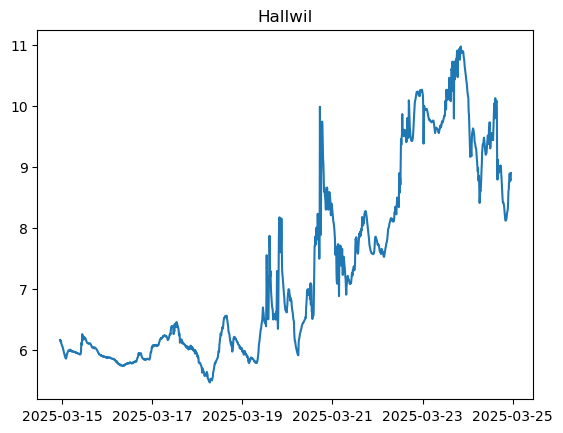

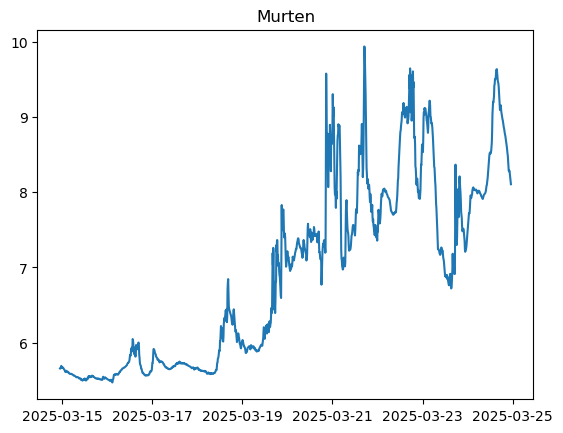

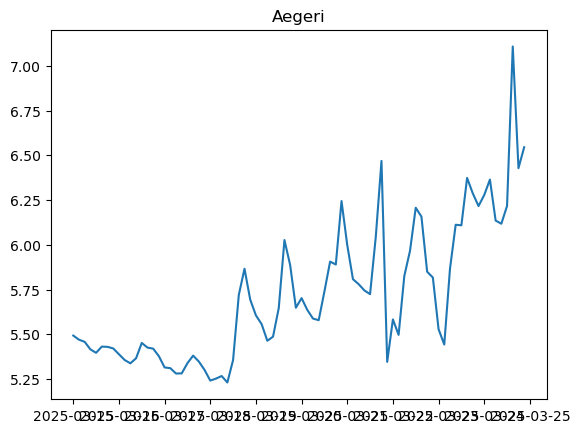

In [29]:
def download_datalakes_data(datalakes_id, depth, start, stop, value_id=5):
    response = requests.get("https://api.datalakes-eawag.ch/datasetparameters?datasets_id={}".format(datalakes_id))    
    if response.status_code != 200:
        raise ValueError("Failed to get datalakes parameters")
    parameters = response.json()
    
    time_axis = [p for p in parameters if p.get("parameters_id") == 1][0]["axis"]
    value_x = [p for p in parameters if p.get("parameters_id") == 5]
    if len(value_x) == 1 :
        value_axis = value_x[0]["axis"]
    else:
        value_xx = [p for p in value_x if "{}m".format(depth) in p["detail"]]
        if len(value_xx) == 1:
            value_axis = value_xx[0]["axis"]
        else:
            raise ValueError("Failed to find value parameter")
    if "z" in value_axis:
        depth_axis = [p for p in parameters if p.get("parameters_id") == 2][0]["axis"]
    
    response = requests.get("https://api.datalakes-eawag.ch/files?datasets_id={}".format(datalakes_id))    
    if response.status_code != 200:
        raise ValueError("Failed to get datalakes files")
    files = response.json()
    files = [f for f in files if f["filetype"] == "json"]
    files = sorted(files, key=lambda x: datetime.strptime(x["maxdatetime"], "%Y-%m-%dT%H:%M:%S.%fZ"), reverse=True)
    file_ids = [files[0]["id"]]
    for i in range(20):
        if datetime.strptime(files[i]["mindatetime"], "%Y-%m-%dT%H:%M:%S.%fZ") > start:
            file_ids.append(files[i+1]["id"])
        else:
            break
    time = []
    values = []
    
    for file_id in file_ids:
        response = requests.get("https://api.datalakes-eawag.ch/files/{}?get=raw".format(file_id))    
        if response.status_code != 200:
            raise ValueError("Failed to get datalakes files")
        data = response.json()
        t = [datetime.fromtimestamp(d) for d in data[time_axis]]
        if "z" in value_axis:
            d_idx = min(range(len(data[depth_axis])), key=lambda i: abs(data[depth_axis][i] - depth))
            v = np.array(data[value_axis])[d_idx, :]
        else:
            v = np.array(data[value_axis])
        time = time + t
        values = values + v.tolist()
    
    df = pd.DataFrame({'time': time,'value': values})
    df = df.dropna()
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values(by='time')
    df = df[(df['time'] >= start) & (df['time'] <= stop)]
    if len(df) < 10:
        raise ValueError("Not enough data to compare")
    #time = df['time'].dt.strftime('%Y-%m-%dT%H:%M:%S+00:00').tolist()
    time = df['time'].tolist()
    values = df['value'].tolist()   
    return {"time": time, "values": values}


tests = [{"id": 448, "depth": 0.25, "name": "Lexplore surface"},
         {"id": 448, "depth": 90, "name": "Lexplore bottom"}, 
         {"id": 597, "depth": 1, "name": "Buchillon"},
         {"id": 1046, "depth": 0.5, "name": "Hallwil"}, 
         {"id": 956, "depth": 1, "name": "Murten"},
         {"id": 1077, "depth": 2, "name": "Aegeri"}
        ]

stop = datetime.now() - timedelta(days=1)
stop = stop.replace(hour=23, minute=0, second=0, microsecond=0)
start = stop - timedelta(days=10)

for test in tests:
    data = download_datalakes_data(test["id"], test["depth"], start, stop)
    plt.plot(data["time"], data["values"])
    plt.title(test["name"])
    plt.show()